In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


mass: mass (in solar masses M⊙)
logg: base-10 logarithm of the surface gravity in CGS units 

In [3]:
def read_data(filename, delim):
  '''
  Input: 
    Directory to the file to be read
    Type of delimiter used in the file

  Output:
    A numpy array composed of all log(g) and mass values in the dataset.
  '''
  data = pd.read_csv(filename, sep = delim)
  return data[['logg', 'mass']].to_numpy()

  
def unit_conversion(logg, mass):
  '''
  This function converts the unit of surface gravity from CGS units to average Earth radii unit.
  '''

  # Define constants

  average_earth_radii = 6371 * 10**3 # m
  gravitation_constant = 6.6743 * 10**-11 # m3 kg-1 s-2
  solar_mass_kg = 1.98847 * 10**30 # kg

  # Convert surface gravity from CGS to SI

  surface_gravity = 10**logg * 10**-2
      
  # Convert solar mass to kg for mass
  mass_kg = solar_mass_kg * mass  

  # Radius in m is calculated from Newton's law of universal gravitation.
  # Radius in m used to convert radius of the star to average earth radii unit
  radius_m = np.sqrt(gravitation_constant * mass_kg / surface_gravity)
  radius_avgEarth = (radius_m) / average_earth_radii

  return radius_avgEarth, mass_kg, radius_m

In [4]:
data_file = '/content/drive/MyDrive/white_dwarf_data.csv'

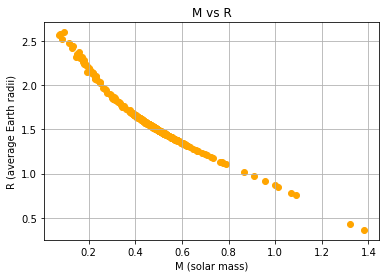

In [5]:
data = read_data(data_file, ',')
logg = data[:, 0]
mass = data[:, 1]
plt.scatter(mass, [unit_conversion(i,j)[0] for i,j in zip(logg, mass)], color = 'orange')
plt.title('M vs R')
plt.xlabel('M (solar mass)')
plt.ylabel('R (average Earth radii)')
plt.grid()
plt.show()

# Q1c. 
In this section we will
  1. Fit the data to find K* and n\*
  2. Using n* and Lane-Emnde equation, find ρc
  3. Plot M vs ρc


In the Lane-Emden equation ξ is a dimensionless radius and θ is related to the density, and thus the pressure, by ρ = ρ$_{c}$θⁿ for central density ρ$_{c}$.
The index *n* is the polytropic index that appears in the polytropic equation of state,
P = K ρ$^{1+1/n}$, where P and ρ are the pressure and density respectively, and K is a constant of proportionality.

Thus, here we will start by giving q and c (proportionality constant of Eq. 7) initial values to iterate further. We will use c to find K.

We are using Eq.7 which gives the relationship between M and R

In [6]:
def mass_radius(R, A, n):
  M  = A * (R ** ((3 - n) / (1 - n)))
  return M 

In [7]:


def lane_emden_solver(n):   
   # We will solve lane emden equation to get propagated span of xi, 
   # theta and theta_dot. We will also deal with the end of the iteration.

    def is_surface(xi, theta, n): return theta[0]
    is_surface.terminal = True
    is_surface.direction = 0

    theta_0 = [1, 0]  # Initial value for theta
    xi_span = [0, 10]  # Initial value for xi and possible span

    r = solve_ivp(fun=lane_emden, t_span=xi_span,
                  y0=theta_0, events=is_surface, args=(n,))

    # If propagation is successful:
    if r.status >= 0:
        return r.t, r.y
    else:
        print("It seems solver is not able to obtain a solution!")

def lane_emden(xi, theta, n):
  # Write the lane emden equation to be used in the solver.
  if xi != 0:
    return np.array([theta[1], (-xi * np.power(theta[0], n, out=np.zeros_like(theta[0]), where=theta[0] > 0) - 2 * theta[1]) / (xi)])
  else:
    return [theta[1], 0]


In [8]:
def fit_curve(low_mass_threshold=None, low_mass = True):
  data = read_data(data_file, ',')
  logg = data[:, 0]
  mass = data[:, 1]
  radius_avgEarth, mass_kg, radius_m = unit_conversion(logg,mass)
  q_initial = 3.0
  A_initial = 9e50 
  if low_mass :
    M = mass_kg[mass < low_mass_threshold]
    R = radius_m[mass < low_mass_threshold]
  else:
    M = mass_kg
    R = radius_m
  if (A_initial is not None) and (q_initial is not None):
      # If A and q are to be optimized
      def create_fitting_function(R, A, q): 
        n = q/(5-q)
        return mass_radius(R = R, n=n, A = A)

  soln1, soln2 = curve_fit(f=create_fitting_function, xdata=R, ydata=M, p0=[A_initial, q_initial])
  A, q = soln1
  # Now that we obtained A and q, we can use A to obtain K. A is a placeholder 
  # for the constant part of mass-radius relation.
  n = q / (5-q) # one of our conditions
  xi, theta = lane_emden_solver(n)
  # The following are required for the mass calculation
  xi_star = xi[-1]
  theta_dot_xi_star = theta[1, -1]
  G = 6.6743 * 10**-11 
  B = (((n + 1) / (4 * np.pi * G)) ** (((n - 3) / (2 - 2 * n)) + 1.5)) * ((xi_star) ** (((n - 3) / (1 - n)) + 2)) * 4 * np.pi * (-theta_dot_xi_star)

  K = (A / B) ** ((n - 1) / (n))
  print('Estimated parameters for the fitted curve are:')
  print(f'K = {K}\nq = {q}\nA = {A}')


  # We know that q is an integer (from theory). Since we cannot constrain a 
  # fitting parameter to be an integer, we will set q to be the nearest integer 
  # Then, we will do a second fit for the other parameter, K∗. 

  # We had q to be around 3 from the previous part, also the suggestion.

  # Set initial guesses as values obtained from the previous part.
  q_fixed = np.round(q) # integer
  A_new = A

  # Following a similar logic, we fit another curve.

  if (A_new is not None) and (q_fixed is not None):
        def create_fitting_function(R, A_new): 
          n = q_fixed/(5-q_fixed)
          return mass_radius(R = R, n=n, A = A_new)

  soln1_new, soln2_new = curve_fit(f=create_fitting_function, xdata=R, ydata=M, p0=[A_new])
  A2= soln1_new


  n = q_fixed / (5-q_fixed) # one of our conditions
  xi, theta = lane_emden_solver(n)
  # The following are required for the mass calculation
  xi_star = xi[-1]
  theta_dot_xi_star = theta[1, -1]
  G = 6.6743 * 10**-11 
  B = (((n + 1) / (4 * np.pi * G)) ** (((n - 3) / (2 - 2 * n)) + 1.5)) * ((xi_star) ** (((n - 3) / (1 - n)) + 2)) * 4 * np.pi * (-theta_dot_xi_star)
  K_new = (A2 / B) ** ((n - 1) / (n))

  print('Estimated parameters for the fitted curve are:')
  print(f'K = {K_new}\nq = {q_fixed}\nA = {A2}')



fit_curve(low_mass_threshold= 0.34)


Estimated parameters for the fitted curve are:
K = 2884454.4921291852
q = 3.001151877245955
A = 8.473442892590138e+50
Estimated parameters for the fitted curve are:
K = [2851072.9563692]
q = 3.0
A = [1.02261333e+51]


# Q2

Plot M vs R curve.

In [9]:
def tov(r, initials, K, n):
  # Equation 12 from the assignment sheet, relating density and pressure.
  # Writing equations 13, 14,15 and 16 from the assignment sheet)
  m, v, p, mp = initials
  rho = (np.abs(p) / K) ** (1/2) # n = 1 for neutron stars

  m_update = 4 * np.pi * (r ** 2) * rho
  v_nominator = (m + 4 * np.pi * (r ** 3) * p)
  v_denominator = (r * (r - 2 * m))    
  if v_denominator != 0:
      v_update = 2 * (v_nominator / v_denominator)
  else: # NoneType Error 
      v_update = 0  

  p_update = -0.5 * (p + rho) * v_update  

  if r != 0: # baryonic mass
      m_p_update = 4 * np.pi * ((1 - ((2 * m) / (r))) ** (-0.5)) * (r ** 2) * rho 
  else:
      m_p_update = 0

  return m_update, v_update, p_update, m_p_update

# Termination criteria
def terminate(r, initials, K, n): 
  m, v, p, mp = initials
  return p - 1e-50

def tov_ivp(pc, K, n):
    # Initial value the variables: mass, time dilation, pressure, baryonic mass:
    initials = [0, 0, pc, 0]
    # Possible radius span
    r_span = [0, 1e15]

    # Solution of the IVP
    terminate.terminal = True
    terminate.direction = 0 # trigger event. 
    r = solve_ivp(fun=tov, t_span=r_span,
                  y0=initials, events=terminate, args=(K, n), max_step = 1)
    points = r.t 
    solution = r.y
    return points, solution


Text(0.5, 1.0, 'Mass-Radius Curve for NSs')

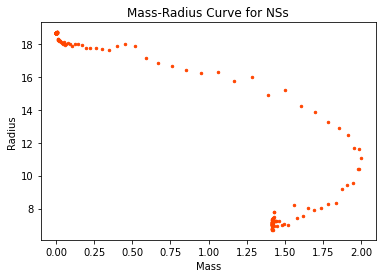

In [145]:
N1 = 100 # # of (K_SN) points
N2 = 200 # # of (p_c) points

gravitation_constant = 6.6743 * 10**-11 # m3 kg-1 s-2
solar_mass_kg = 1.98847 * 10**30 # kg
speed_of_light = 299792458.0 # m s^-1
n = 1

# Set values to go through for constant K
kns_points = np.arange(N1 - int(N1 / 2) + 1,100 + int(N1 / 2))
# Get the actual size of the constructed array
N1 = len(kns_points)

# In the units that are designed such that the values of physical quantities in 
#this problem will be around unity. There we haveKNS ≈ 100. Find its location.
ind = np.where(kns_points == 100)[0][0]


# Generate central pressure sampling points, convert to geometric units.
cp = np.logspace(18, 45, N2) * (((gravitation_constant ** 3) * (solar_mass_kg ** 2)) / (speed_of_light ** 8))

# Create containers for TOV equation variables
mass = np.empty((N1, N2))
radius = np.empty((N1, N2))
bary_mass = np.empty((N1, N2))

# Iteration 
for i in range(len(kns_points)):
    for j in range(len(cp)):
        # Solution of the TOV equations
        points, solution = tov_ivp(cp[j], kns_points[i], n)
        # Get the latest element of mass, radius and rest mass solutions
        mass[i, j] = solution[0, -1]
        bary_mass[i, j] = solution[-1, -1]
        radius[i, j] = points[-1]



# Pressure to density conversion, from equation 9.
rho = (np.abs(p) / kns_points[ind]) ** (1/2) # n = 1 for neutron stars
# Geometric unit to SI unit conversion
rho_si = rho / (((gravitation_constant ** 3) * (solar_mass_kg ** 2)) / (speed_of_light ** 6))
radius_si = radius * ((gravitation_constant * solar_mass_kg) / (speed_of_light ** 2)) / 1000

plt.scatter(mass[ind, :],radius_si[ind, :] , s= 6, c = 'orangered')
plt.xlabel('Mass')
plt.ylabel('Radius')
plt.title('Mass-Radius Curve for NSs')

b. Plot ∆ vs R. 
As suggested fractional binding energy is obtained in above integration using formula 16 and 17.

Text(0.5, 1.0, 'Fractional Binding Energy-Radius Curve for NSs')

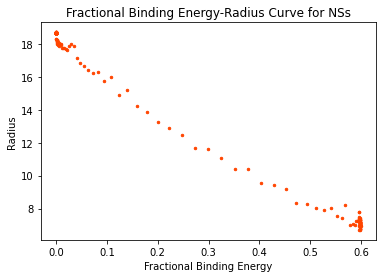

In [95]:
frac_bind_energy = (bary_mass - mass) / mass 
plt.scatter(frac_bind_energy[ind, :], radius_si[ind, :] , s= 6, c = 'orangered' )
plt.xlabel('Fractional Binding Energy')
plt.ylabel('Radius')
plt.title('Fractional Binding Energy-Radius Curve for NSs')

c. Plot the M vs ρc curve. Stability criteria are given in equation18 and 19. We need to take derivative of M wrt pc.

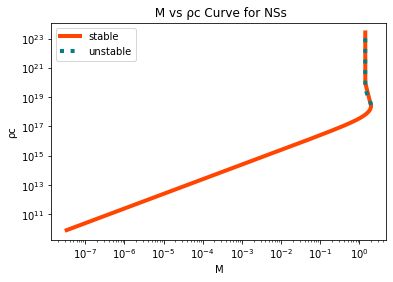

In [123]:
derivative = np.gradient(mass[ind, :], rho_si)
stable_dict = []
instable_dict = []

for i in range(len(derivative)):
  if derivative[i] < 0:
    instable_dict.append(i)
  else:
    stable_dict.append(i)

stable_mass = mass[ind, stable_dict]
stable_rho = rho_SI[stable_dict]
instable_mass = mass[ind, instable_dict]
instable_rho = rho_SI[instable_dict]
plt.loglog(stable_mass, stable_rho, c = 'orangered',  linewidth=4.0, label = 'stable')
plt.loglog( instable_mass, instable_rho, c= 'teal', linestyle = 'dotted', linewidth=4.0, label = 'unstable')
plt.legend()
plt.xlabel('M')
plt.ylabel('ρc')
plt.title(' M vs ρc Curve for NSs')
plt.legend()

d. Plot Mmax(K) vs K

No handles with labels found to put in legend.
No handles with labels found to put in legend.


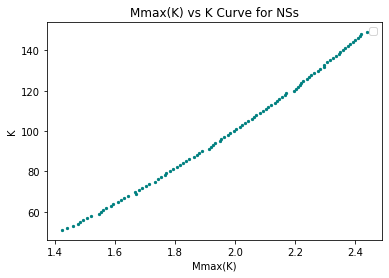

In [127]:
# Get of the maximum masses for each polytopic constant from the mass container.
mass_max = np.max(mass, axis = 1)
plt.scatter(mass_max, kns_points, c = 'teal', s = 5)
plt.legend()
plt.xlabel('Mmax(K)')
plt.ylabel('K')
plt.title('Mmax(K) vs K Curve for NSs')
plt.legend()

The most massive neutron star to be observed so far has a mass of 2.14M⊙, we'll use this value to constraint maximum mass

In [140]:
max_allowable = np.where(np.isclose(mass_max, 2.14, atol = 0.01))
max_allowable_kns_y = mass_max[max_allowable][0]
max_allowable_kns_x_lower = kns_points[0]
max_allowable_kns_x_upper = kns_points[-1]


In [141]:
max_allowable_m_x = [kns_points[max_allowable][0]]
max_allowable_m_y_lower = mass_max[0]
max_allowable_m_y_upper =  mass_max[-1]

In [143]:
print(f'Maximum value allowed for K is {max_allowable_kns_x_upper}')


Maximum value allowed for K is 149


No handles with labels found to put in legend.
No handles with labels found to put in legend.


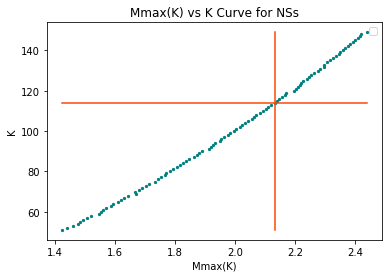

In [154]:
plt.plot(np.array([mass_max[max_allowable][0], mass_max[max_allowable][0]]),np.array([max_allowable_kns_x_lower, max_allowable_kns_x_upper ]), color = "orangered")
plt.plot(np.array(np.array([max_allowable_m_y_lower, max_allowable_m_y_upper])), [kns_points[max_allowable][0], kns_points[max_allowable][0]], color = "orangered")
plt.scatter(mass_max, kns_points, c = 'teal', s = 5)
plt.legend()
plt.xlabel('Mmax(K)')
plt.ylabel('K')
plt.title('Mmax(K) vs K Curve for NSs')
plt.legend()
